# fMRI-05 Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

This notebook demonstrates a number of important postprocessing steps in fMRI analysis.

## Part 1: Smoothing

Often fMRI data are spatially smoothed prior to analysis. The extent of spatial smoothing will be dependent on your analysis of interest (e.g. studying large or small ROIs). Smoothing can be accomplished with a number of functions. Volumetric (Gaussian) smoothing can be performed with e.g. `nilearn` ([nilearn.image.smooth_img](https://nilearn.github.io/modules/generated/nilearn.image.smooth_img.html#nilearn.image.smooth_img)) or AFNI ([3dBlurInMask](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dBlurInMask.html) or [3dBlurToFWHM](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dBlurToFWHM.html)).

Smoothing cortical data on the surface may better respect the spatial relationships among cortical data, and can be done with AFNI ([SurfSmooth](https://afni.nimh.nih.gov/pub/dist/doc/program_help/SurfSmooth.html)) or FreeSurfer ([mri_fwhm](https://surfer.nmr.mgh.harvard.edu/fswiki/mri_fwhm) and [mri_surf2surf](http://freesurfer.net/fswiki/mri_surf2surf) (see [here](https://github.com/snastase/smoothing-afni) for brief demo of AFNI smoothing).

## Part 2: Temporal filtering

To remove low frequency drifts in the fMRI signal, we often high-pass filter the data before analysis. This can be performed in a number of ways, but thankfully `nilearn` makes this very easy for us. We will use the `clean` function to highpass filter the data. The appropriate frequency cutoff may depend on your particular experiment, but standard default values are 1/100 (0.01) Hz, 1/128 Hz (0.0078), and 1/200 (0.005) Hz. We'll also standardize the time series to percent signal change ([Chen et al. 2017](https://www.sciencedirect.com/science/article/pii/S1053811916305432)).

In [2]:
from os.path import join
import nibabel as nib
from nilearn.signal import clean

# Point to fMRIPrep outputs.
fmriprep_dir = join('/jukebox/PNI-classes/students/NEU502/2021/fmriprep-demo',
                    'sample_project_output_v20.2.0/data/bids/derivatives/fmriprep')

## Define metadata.
tr = 1.5
high_pass = 1/128

## Load data.
bold_fn = join(fmriprep_dir, 'sub-001', 'ses-01', 'func',
               'sub-001_ses-01_task-faces_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
data = nib.load(bold_fn).get_fdata()

mask_fn = join(fmriprep_dir, 'sub-001', 'ses-01', 'func',
               'sub-001_ses-01_task-faces_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')
mask = nib.load(mask_fn).get_fdata().astype(bool)

data_masked = data[mask].T
               
## Apply high-pass data.
data_clean = clean(data_masked, detrend=True, standardize='psc', high_pass=high_pass, t_r=tr)

/jukebox/hasson/snastase/miniconda3/envs/neu502b/lib/python3.7/site-packages/nilearn/signal.py:81: UserWarning: psc standardization strategy is meaningless for features that have a mean of 0 or less. These time series are set to 0.
  warnings.warn('psc standardization strategy is meaningless '


## Part 3: Confound regression 

Nuisance regressors describe additional timeseries we will include in our design matrix that will control for sources of noise in our data. Noise sources might include scanner artifact (e.g. drifts), motion artifact, and respiratory artifact.

### Head motion
The biggest source of noise is motion. We can effectively mitigate first-order motion effects (i.e. artifact immediately following a movement) using motion regressors. Motion regressors are estimates of the brain's movement in six directions (left/right, forward/backward, up/down, pitch, yaw, roll) over the course of the scan.

In [3]:
from pandas import read_table
from nilearn.signal import clean

## Load fmriprep confound regressors.
confounds_fn = join(fmriprep_dir, 'sub-001', 'ses-01', 'func',
                    'sub-001_ses-01_task-faces_run-1_desc-confounds_timeseries.tsv')
df = read_table(confounds_fn, sep='\t')

## Extract motion regressors.
hm_labels = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
hm = df[hm_labels].values

### Motion censoring
With large movements, we might decide that a particular volume is suspect. In other words, if a participant moves their head too much, our motion regressors may not be able to compensate for signal deviations. In such instances, it may be preferable to use "motion scrubbers". These are nuisance regressors that are columns of zeros *except* for the infected volume, where a 1 is inserted instead. These act to effectively remove entirely the influence of that volume from the regression.

The threshold for what constitutes a large movement is not set in stone. For children or psychiatric patients, we expect more motion than "healthy" controls. Thankfully some guidelines have been put forward ([Power et al. 2014](https://www.ncbi.nlm.nih.gov/pubmed/23994314), [Siegel et al. 2014](https://www.ncbi.nlm.nih.gov/pubmed/23861343)). A rough threshold is to reject any volume with a framewise displacement value above 0.5 mm. This may need to be adjusted depending on the level of motion of the participant (of course, if a participant is moving a lot it is better just to throw away their data!). If 10%-20% of a participant's data is going to be rejected with even a liberal threshold (e.g. FD = 1.0mm), it may be better to exclude that participant's data.

0 bad volumes detected.


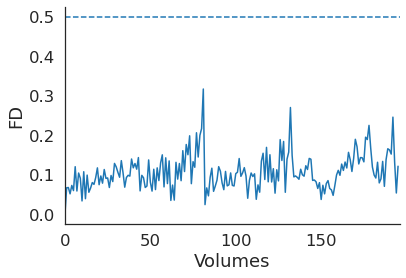

In [4]:
from pandas import read_table

## Define FD threshold.
fd_threshold = 0.5

## Extract framewise displacement.
fd = df['framewise_displacement'].values
fd[np.isnan(fd)] = 0

## Identify infected volumes.
bad_vols = np.argwhere(fd > fd_threshold)
print('%s bad volumes detected.' %bad_vols.size)

## Construct scrubbers.
scrubbers = np.zeros((fd.size, bad_vols.size))
scrubbers[bad_vols, np.arange(fd.size)] = 1

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(fd)
ax.hlines(fd_threshold, 0, fd.size, linestyle='--')
ax.set(xlim=(0, fd.size), xlabel='Volumes', ylabel='FD')
sns.despine()

### CompCor regressors

To remove physiological noise (e.g. respiration), some data-driven methods have been developed that come standard in fMRIPrep. One such example is component based noise correction method (CompCor) ([Behzadi et al. 2007](https://www.sciencedirect.com/science/article/pii/S1053811907003837?via%3Dihub])). Anatomical CompCor (aCompCor) attempts to estimate physiological noise from regions of the brain where we can be certain there is little-to-no neural activity (e.g. cerebrospinal fluid, white matter). The timecourses from these regions are extracted and passed through a semi-supervised dimensionality reduction processes. These are also available in fmriprep.

These may be helpful in removing respiration noise from your data, but one must be careful. If you expect that your task may accidentially cause respiration-task correlations (e.g. participant sighs relief at the end of hard trials), then this method may inadvertently remove task-related signal from your data.

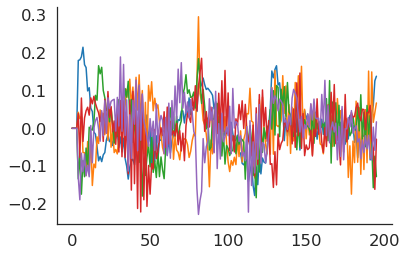

In [5]:
from pandas import read_table
from nilearn.signal import clean

## Extract 5 anatomical compcor signals.
acompcor_n = 5
acompcor_labels = [f'a_comp_cor_0{n}' for n in range(acompcor_n)]
acompcor = df.filter(acompcor_labels).values

## Plot.
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(acompcor)
sns.despine()

## Regression
To avoid reintroducing artifacts, we should combine our high-pass filter, de-trending, and confounds into a single regression equation ([Lindquist et al., 2019](https://doi.org/10.1002/hbm.24528)). For some types of data, e.g. resting-state or some naturalistic paradigms, there's no obvious experimental event structure and we really just want to clean up the data—like in this example. However, for traditional experiments with blocks or events, we would want to combine these confound regressors with our *regressors of interest* and fit a single model with both.

/jukebox/hasson/snastase/miniconda3/envs/neu502b/lib/python3.7/site-packages/nilearn/signal.py:77: RuntimeWarning: divide by zero encountered in true_divide
  signals = (signals / mean_signal) * 100
/jukebox/hasson/snastase/miniconda3/envs/neu502b/lib/python3.7/site-packages/nilearn/signal.py:81: UserWarning: psc standardization strategy is meaningless for features that have a mean of 0 or less. These time series are set to 0.
  warnings.warn('psc standardization strategy is meaningless '


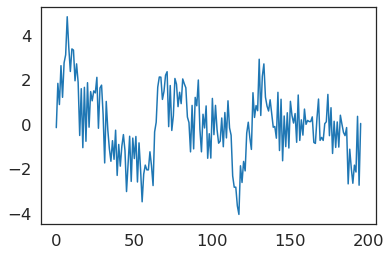

In [6]:
# Combine various confound regressors.
confounds = np.column_stack((hm, acompcor))

# Re-run confound regression with high-pass filter
data_clean = clean(data_masked, confounds=confounds, detrend=True,
                   high_pass=high_pass, standardize='psc', t_r=tr)

# Plot an arbitrary voxel time series
voxel = 100
plt.plot(data_clean[:, voxel]);